# Measurement Error Mitigation
Comparing VQE with and without noise/mitigation. 

See: https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html

In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.operators import I, X, Z

In [3]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [4]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


In [5]:
seed = 170
iterations = 125
aqua_globals.random_seed = seed
backend = Aer.get_backend('qasm_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(var_form=var_form, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85464
Delta from reference energy value is 0.00264


Text(0.5, 1.0, 'Convergence with no noise')

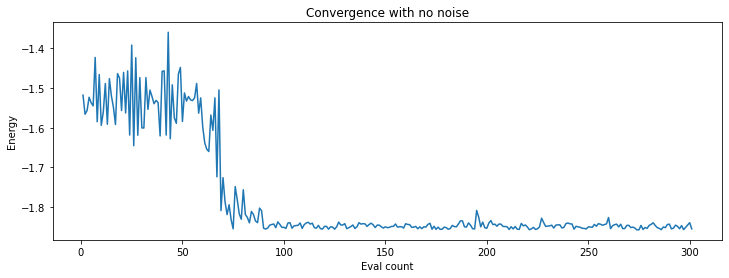

In [6]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

In [8]:
import os
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('qasm_simulator')
counts1 = []
values1 = []
noise_model = None
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

aqua_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(var_form=var_form, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'id', 'u3', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]

VQE on Aer qasm simulator (with noise): -1.83519
Delta from reference energy value is 0.02208


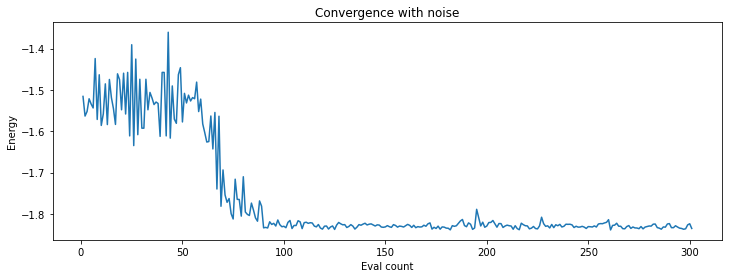

In [9]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

In [10]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    aqua_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls=CompleteMeasFitter,
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(var_form=var_form, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.85490
Delta from reference energy value is 0.00237
